In [44]:
import numpy as np
import pandas as pd
from participantgenerator.tablegenerator import subjectgenerator
from datetime import datetime, timedelta
import uuid
import time
import random
from IPython.display import display_html 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('colheader_justify', 'left')

# Utilities

In [45]:
def random_date_in_date_range(start, end):
    #current time in unix utc
    start_timestamp = datetime.strptime(start,'%Y-%m-%d').timestamp()
    end_timestamp = datetime.strptime(end,'%Y-%m-%d').timestamp()

    random_timestamp = np.random.randint(start_timestamp, end_timestamp)
    
    random_date = datetime.fromtimestamp(random_timestamp).strftime('%Y-%m-%d')
    
    return random_date

In [46]:
def random_date_up_to_x_days_after_previous_date(date, days):
    timestamp = datetime.strptime(date,'%Y-%m-%d').timestamp()
    days_in_seconds = days*24*60*60
    one_day = 24*60*60
    time_difference = np.random.randint(days_in_seconds) + one_day #add a day so possible range is 1-x days rather than 0-x
    new_date = datetime.fromtimestamp(timestamp + time_difference).strftime('%Y-%m-%d')
    return new_date

In [47]:
def random_date_up_to_x_days_before_previous_date(date, days):
    timestamp = datetime.strptime(date,'%Y-%m-%d').timestamp()
    days_in_seconds = days*24*60*60
    one_day = 24*60*60
    time_difference = np.random.randint(abs(days_in_seconds)) + one_day #add a day so possible range is 1-x days rather than 0-x
    new_date = datetime.fromtimestamp(timestamp - time_difference).strftime('%Y-%m-%d')

    return new_date

In [48]:
def get_date_diff(date1, date2):
    date1timestamp = datetime.strptime(date1, '%Y-%m-%d').timestamp()
    date2timestamp = datetime.strptime(date2, '%Y-%m-%d').timestamp()
    difference = date1timestamp - date2timestamp
    days = round(difference/86400)
    return days

In [49]:
def get_random_officer(row, df):
    if row['HearingType'] == "Probation":
        officer = df[df['Type'] == "Probation Officer"].sample(1)
        officer = officer.to_dict('records')[0]
    elif row['HearingType'] == "Parole":
        officer = df[df['Type'] == "Parole Officer"].sample(1)
        officer = officer.to_dict('records')[0]
    else:
        officer = {'lastName': np.NaN,
                     'firstName': np.NaN,
                     'middleName': np.NaN,
                     'Type': np.NaN,
                     'Email': np.NaN,
                     'PhoneNo': np.NaN}
    return officer

In [50]:
def get_random_attorney(row, df):
    if row['HearingType'] in ["Parole","Probation"]:
        attorney = df[df['Type'] == "Attorney"].sample(1)
        attorney = attorney.to_dict('records')[0]
    else:
        attorney = {'lastName': np.NaN,
                     'firstName': np.NaN,
                     'middleName': np.NaN,
                     'Type': np.NaN,
                     'Email': np.NaN,
                     'PhoneNo': np.NaN}
    return attorney

In [51]:
def make_records_with_selection_from_a_df(df1, columns):

    selection = df1[columns].to_dict("records")

    return selection

In [52]:
def make_records_with_selection_from_multiple_dfs(df1, df2, key, columns):

    tempdf = df1.set_index(key).join(df2.set_index(key),lsuffix='_l', rsuffix='_r').reset_index()
    selection = tempdf[columns].to_dict("records")

    return selection

In [53]:
# from 2018 census
education_dict = {
    "Elementary or High school, no diploma": 14.2/100,
    "9th grade, no diploma": 7./100,
    "10th grade, no diploma": 7./100,
    "11th grade, no diploma": 7./100,
    "12th grade, no diploma": 4.4/100,
    'Elementary or High school, GED': 28.5/100,
    'High school diploma': 20.5/100,
    "Postsecondary/Some College": 11.4/100
}
gender_dict = {
    'Male': 0.5, 
    "Female": 0.3, 
    "Non-Binary": 0.02, 
    "Transgender (Male to Female)": 0.02, 
    "Transgender (Female to Male)": 0.02, 
    "Other": 0.03, 
    "Unknown": 0.02, 
    "Decline to State": 0.08, 
    "Not Asked":0.02
}
marital_dict = {
    'Single': 0.3 , 
    'Married': 0.3, 
    'Widowed': 0.1, 
    'Separated': 0.05, 
    'Divorced': 0.15, 
    'Domestic Partner': 0.05, 
    'Common Law': 0.05
}
sex_offender_counties = {
    'Marin': 0.05 , 
    'Sonoma': 0.05, 
    'Napa': 0.05, 
    'Solano': 0.05, 
    'Contra Costa': 0.1, 
    'Alameda': 0.05, 
    'Santa Clara': 0.05,
    'San Mateo': 0.3,
    'San Francisco': 0.3
}
# very rough guestimates based on https://www.nami.org/learn-more/public-policy/jailing-people-with-mental-illness
# better sources and statistics would be good
mental_health_status = {
    'Male':{
        'High': 0.15,
        'Medium': 0.2,
        'Low': 0.3,
        'None': 0.35
    },
    'Female':{
        'High': 0.3,
        'Medium': 0.3,
        'Low': 0.1,
        'None': 0.3
    }
}

In [54]:
class Inmate():
    '''
    Makes inmate based on subjectgenerator - also gives them Education, SubjectIdentification, 
    sex, Gender, MaritalStatus, SexOffender, SexOffenderCounty,  Education, MentalHealthStatus
    '''
    def __init__(self, key):
        
        self.inmate = subjectgenerator.subject()
        self.inmate.generate()
        self.inmate = vars(self.inmate)['subject']
        self.inmate['Education'] = np.random.choice(list(education_dict.keys()), p = list(education_dict.values()))
        self.inmate['SubjectIdentification'] = str(uuid.uuid1())
        
        # make sex correspond to  gender 
        # TODO: fix with better distributions
        if self.inmate['sex'] == 'M':
            self.inmate['Gender'] = 'Male'
        elif self.inmate['sex'] == 'F':
            self.inmate['Gender'] = 'Female'

        roughage = int(datetime.today().strftime('%Y')) - int(self.inmate['dob'][:4])
        
        # generate MaritalStatus
        self.inmate['MaritalStatus'] =  np.random.choice(list(marital_dict.keys()), p = list(marital_dict.values())) \
            if roughage > 20 else "Single"
        
        # generate Juvenile
        
        self.inmate['Juvenile'] =  "Yes"  if roughage < 18 else "No"

        # generate SexOffender
        self.inmate['SexOffender'] = np.random.choice(["Y", "N"], p = [0.4, 0.6]) if \
            roughage > 20 else np.random.choice(["Y", "N"], p = [0.4, 0.6])
        
        if self.inmate['SexOffender'] == 'Y':
            self.inmate['SexOffenderCounty'] = np.random.choice(list(sex_offender_counties.keys()), p = list(sex_offender_counties.values()))
        
        # generate Education
        self.inmate['Education'] = np.random.choice(list(education_dict.keys()), p = list(education_dict.values()))
        
        # generate MentalHealthStatus
        if self.inmate['sex'] == 'M':
            self.inmate['MentalHealthStatus'] = np.random.choice(list(mental_health_status['Male'].keys()), p = list(mental_health_status['Male'].values()))
        elif self.inmate['sex'] == 'F':
            self.inmate['MentalHealthStatus'] = np.random.choice(list(mental_health_status['Female'].keys()), p = list(mental_health_status['Female'].values()))

    @property
    def __dict__(self):
        return self.inmate

In [55]:
class AttorneyOfficer():
    '''
    Creates Attorneys, Probation Officers, and Parole officers from subjectgenerator
    key is unneccesary - i have to fix make_df to remove it
    '''
    def __init__(self, key):
        self.attorneyofficer = subjectgenerator.subject()
        self.attorneyofficer.generate()
        self.attorneyofficer = {k: vars(self.attorneyofficer)['subject'][k] for k in vars(self.attorneyofficer)['subject'].keys() & {'firstName', 'lastName', 'middleName'}}
#         self.attorneyofficer['key'] = key
        self.attorneyofficer['Type'] = np.random.choice(['Attorney', 'Probation Officer', 'Parole Officer'], p = [0.3,0.3,0.4])
        self.attorneyofficer['Email'] = f"{self.attorneyofficer['firstName'][0].lower()}{self.attorneyofficer['lastName'].lower()}@ol.gov"
        self.attorneyofficer['PhoneNo'] = f"({str(random.randint(100,999))}) {str(random.randint(1,888)).zfill(3)}-{str(random.randint(1,9999)).zfill(4)}"

    @property
    def __dict__(self):
        return self.attorneyofficer

In [56]:
class Courtcase():
    docketno = 100000
    '''
    Takes a dict with SubjectIdentification and MentalHealthStatus
    Gives an inmate a number of courtcases as a function of their MentalHealthStatus
    Creates DocketNo, which is unique for each courtcase
    Returns a list of dicts for each dict input
    '''
    def __init__(self, mhdict):
        
        self.courtcases = []
            
        if mhdict['MentalHealthStatus'] == 'None':
            mu, sigma = 0.5, 0.5
            additional_cases = round(1 + np.random.lognormal(mu, sigma))
            num_cases = np.random.choice([1, additional_cases], p=[.94,.06])
        elif mhdict['MentalHealthStatus'] == 'Low':
            mu, sigma = 0.6, 0.4
            additional_cases = round(1 + np.random.lognormal(mu, sigma))
            num_cases = np.random.choice([1, additional_cases], p=[.95,.05])
        elif mhdict['MentalHealthStatus'] == 'Medium':
            mu, sigma = 0.7, 0.35
            additional_cases = round(1 + np.random.lognormal(mu, sigma))
            num_cases = np.random.choice([1, additional_cases], p=[.73,.27])
        if mhdict['MentalHealthStatus'] == 'High':
            mu, sigma = 0.8, 0.3
            additional_cases = round(1 + np.random.lognormal(mu, sigma))
            num_cases = np.random.choice([1, additional_cases], p=[.76,.24])

        for i in range(num_cases):

            self.courtcase = {}
            self.courtcase['SubjectIdentification'] = mhdict['SubjectIdentification']
            self.courtcase['DocketNo'] = self.docketno
            self.courtcases.append(self.courtcase)
            Courtcase.docketno += 1
    
    @property
    def __dict__(self):
        return self.courtcases

In [57]:
hearing_dict = {
    "Pre-Trial": 0.2,
    "Motions": 0.3,
    "Court Trial": 0.2,
    "Jury Trial": 0.05,
    "Terminal disposition": 0.25
}

In [58]:
class Hearings():
    '''
    Creates Hearings based on a dict which has SubjectIdentification, MentalHealthStatus, and DocketNo (courtcase ID)
    Each courtcase has between 1-7 hearings before sentencing or probation
    The first hearing is always arraignment. It takes place on a random date from 2015-01-01 to today
    If it is the second or greater hearing, this_hearing_date is generated as a random date up to 60 days after the most recent hearing for this docketno
    if this_hearing_date is in the future, the loop breaks and no more hearings are generated
    If the hearingnumber is =  the number of hearings before probation or sentencing, the hearing is randomly either probation or sentencing
    If it is a probation hearing, the person is assigned a probation officer and an attorney (called ProbationAttorney), this_hearing_date is the hearing date
    If it is not a probation hearing , then it is a sentencing hearing, this_hearing_date is the hearing date
    '''
    def __init__(self, sdmhdict):
        
        today = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d')

        num_hearings_before_sentencing_or_probation = 1 + np.random.choice(6)

        self.hearings = []

        
        
        for hearingnumber in range(num_hearings_before_sentencing_or_probation):
            self.hearing = {}
            self.hearing['SubjectIdentification'] = sdmhdict['SubjectIdentification']
            self.hearing['DocketNo'] = sdmhdict['DocketNo']
            self.hearing['MentalHealthStatus'] = sdmhdict['MentalHealthStatus']
            



            if hearingnumber == 0:
                self.hearing['HearingType'] = 'Arraignment'
                self.hearing['HearingDate'] = random_date_in_date_range('2015-01-01', today)


            elif hearingnumber > 0:
                last_hearing_date = [x['HearingDate'] for x in self.hearings][-1]

                this_hearing_date = random_date_up_to_x_days_after_previous_date(last_hearing_date, 60)


                if this_hearing_date >= today:
                    break
                        
                #Sentencing Hearing = final hearing - Determines SentenceId, SentenceDate, SentenceTermStart,a SentenceEndDate
                if hearingnumber == num_hearings_before_sentencing_or_probation-1:

                    probation = np.random.choice(['Yes','No'], p=[0.6, 0.4])

                    if probation == "Yes":
                        self.hearing['HearingType'] = 'Probation'
                        self.hearing['HearingDate'] = this_hearing_date


                    elif probation == "No":
                        self.hearing['HearingType'] = 'Sentencing'
                        self.hearing['HearingDate'] = this_hearing_date
                        
                elif 0 < hearingnumber < num_hearings_before_sentencing_or_probation-1:
                    self.hearing['HearingType'] = np.random.choice(list(hearing_dict.keys()), p = list(hearing_dict.values()))
                    self.hearing['HearingDate'] = this_hearing_date

            self.hearings.append(self.hearing)

    @property
    def __dict__(self):
        return self.hearings

In [59]:
class Sentence():
    '''
    Creates a sentence based on a dict with a HearingDate, MentalHealthStatus and SubjectIdentification
    SentenceId is incremented for each sentence created
    SentenceDate is created as a random date up to 60 days after HearingDate
    SentenceStartDate is created as a random date up to 60 days after SentenceDate
    SentenceEndDate is created based on one of four lognormal distributions, each corresponding to a different MentalHealthStatus
    '''
    sentenceid = 30000
    def __init__(self, hearingdict):
        self.sentence = {}
        self.sentence['HearingDate'] = hearingdict['HearingDate']
        self.sentence['SubjectIdentification'] = hearingdict['SubjectIdentification']
        self.sentence['MentalHealthStatus'] = hearingdict['MentalHealthStatus']
        self.sentence['SentenceId'] = self.sentenceid
        self.sentence['DocketNo'] = hearingdict['DocketNo']
        self.sentence['SentenceDate'] = random_date_up_to_x_days_after_previous_date(self.sentence['HearingDate'], 60)
        self.sentence['SentenceStartDate']= random_date_up_to_x_days_after_previous_date(self.sentence['SentenceDate'], 30)
        
        # generate sentence end date AS A FUNCTION OF mental health status
        if self.sentence['MentalHealthStatus'] == "None":
            mu, sigma = -0.7, 0.4
            num_days = round(np.random.lognormal(mu, sigma) * 100)
            self.sentence['SentenceEndDate'] = random_date_up_to_x_days_after_previous_date(self.sentence['SentenceStartDate'], num_days)

        elif self.sentence['MentalHealthStatus'] == "Low":
            mu, sigma = -0.4, 0.5
            num_days = round(np.random.lognormal(mu, sigma) * 100)
            self.sentence['SentenceEndDate'] = random_date_up_to_x_days_after_previous_date(self.sentence['SentenceStartDate'], num_days)

        elif self.sentence['MentalHealthStatus'] == "Medium":
            mu, sigma = 0, 0.3
            num_days = round(np.random.lognormal(mu, sigma) * 100)
            self.sentence['SentenceEndDate'] = random_date_up_to_x_days_after_previous_date(self.sentence['SentenceStartDate'], num_days)

        elif self.sentence['MentalHealthStatus'] == "High":
            mu, sigma = 0.3, 0.4
            num_days = round(np.random.lognormal(mu, sigma) * 100)
            self.sentence['SentenceEndDate'] = random_date_up_to_x_days_after_previous_date(self.sentence['SentenceStartDate'], num_days)
        
        Sentence.sentenceid += 1
    @property
    def __dict__(self):
        return self.sentence

In [60]:
facility_dict = {
    "Solano":0.17,
    "Quentin":0.1,
    "Folsom":0.13,
    "Doomsby":0.15,
    "Shutter Island":0.05,
    "Nova":0.2,
    "Arkham": 0.08,
    "Wakefield":0.12
}

In [61]:
release_dict = {
    "None": {
        "Bail":0.17,
        "Court Order":0.1,
        "Expiration of Maximum Sentence":0.13,
        "Holding Authority":0.15,
        "Mental Patient Release/Transfer":0.05,
        "Paroled":0.2,
        "Payment of Fines and Costs": 0.08,
        "Transfer":0.12
    },
    "Low": {
        "Bail":0.17,
        "Court Order":0.1,
        "Expiration of Maximum Sentence":0.13,
        "Holding Authority":0.15,
        "Mental Patient Release/Transfer":0.05,
        "Paroled":0.2,
        "Payment of Fines and Costs": 0.08,
        "Transfer":0.12
    },
    "Medium": {
        "Bail":0.17,
        "Court Order":0.1,
        "Expiration of Maximum Sentence":0.13,
        "Holding Authority":0.15,
        "Mental Patient Release/Transfer":0.05,
        "Paroled":0.2,
        "Payment of Fines and Costs": 0.08,
        "Transfer":0.12
    },
    "High": {
        "Bail":0.17,
        "Court Order":0.1,
        "Expiration of Maximum Sentence":0.13,
        "Holding Authority":0.15,
        "Mental Patient Release/Transfer":0.05,
        "Paroled":0.2,
        "Payment of Fines and Costs": 0.08,
        "Transfer":0.12
    }
}

In [62]:
class Jailstay():
    '''
    Makes Jailstays from sentencedicts which contain SentenceId, MentalHealthStatus, SentenceStartDate, SentenceEndDate
    BookId increments for each jailstay created
    ReleaseType is randomly selected based on a nested dictionary which has different probabilities by MentalHealth Status
    If ReleaseType is Paroled, person is assigned a paroleofficer and paroleattorney
    If releasetype is one of bail, payment of fines and costs, or court order, the person is released on a random date between the start and end of their sentence
    If release type is one of 'Expiration of Maximum Sentence', 'Holding Authority', 'Transfer', 'Mental Patient Release/Transfer', the releasedate is the sentence end date
    ReleaseDate is recorded and Jailstaylength is calculated for self.jailstay if release_date is not in the future
    A facility is randomly assigned from facility_dict
    '''
    bookid = 6000
    def __init__(self, sentencedict):
        today = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d')
        self.jailstay = {}
        self.jailstay['SentenceId'] = sentencedict['SentenceId']
        self.jailstay['MentalHealthStatus'] = sentencedict['MentalHealthStatus']
        self.jailstay['SubjectIdentification'] = sentencedict['SubjectIdentification']
        self.jailstay['DocketNo'] = sentencedict['DocketNo']
        self.jailstay['BookId'] = self.bookid
        
        #select release type based on release_dict probabilities - broken down by mentalhealthstatus
        self.jailstay['ReleaseType'] =  np.random.choice(list(release_dict[self.jailstay['MentalHealthStatus']].keys()), p=list(release_dict[self.jailstay['MentalHealthStatus']].values()))
        
        if self.jailstay['ReleaseType'] == 'Paroled':
            release_date = random_date_in_date_range(sentencedict['SentenceStartDate'],sentencedict['SentenceEndDate'])
            
            
        elif self.jailstay['ReleaseType'] in ['Bail', 'Payment of Fines and Costs' ,'Court Order']:
            release_date = random_date_in_date_range(sentencedict['SentenceStartDate'],sentencedict['SentenceEndDate'])

        elif self.jailstay['ReleaseType'] in ['Expiration of Maximum Sentence', 'Holding Authority', 'Transfer', 'Mental Patient Release/Transfer']:
            release_date = sentencedict['SentenceEndDate']
        Jailstay.bookid += 1
        
        
        
        if release_date < today:
            self.jailstay['ReleaseDate'] = release_date
            self.jailstay['JailstayLength'] = get_date_diff(self.jailstay['ReleaseDate'], sentencedict['SentenceStartDate'])


        self.jailstay['Facility'] = np.random.choice(list(facility_dict.keys()), p=list(facility_dict.values()))
    @property
    def __dict__(self):
        return self.jailstay

In [63]:
class Parolecase():
    caseno = 30000
    def __init__(self, sdrdict):
        self.parolecase = {}
        self.parolecase['SubjectIdentification'] = sdrdict['SubjectIdentification']
        self.parolecase['DocketNo'] = f"pr-{self.caseno}"
        self.parolecase['ReleaseDate'] = sdrdict['ReleaseDate']
        Parolecase.caseno += 1
        
    @property
    def __dict__(self):
        return self.parolecase

In [64]:
class ParoleHearings():
    def __init__(self, pcdict):
        today = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d')
        parole_hearing_number = 1 + np.random.choice(5)
        self.hearings = []
        for hearingnumber in range(parole_hearing_number):
            self.hearing = {}
            self.hearing['HearingType'] = 'Parole'
            self.hearing['SubjectIdentification'] = pcdict['SubjectIdentification']
            self.hearing['ReleaseDate'] = pcdict['ReleaseDate']
            self.hearing['DocketNo'] = pcdict['DocketNo']
            
            if hearingnumber == 0:
                self.hearing['HearingDate'] = random_date_up_to_x_days_after_previous_date(pcdict['ReleaseDate'], 30)
                
            elif hearingnumber > 0:
                last_hearing_date = [x['HearingDate'] for x in self.hearings][-1]
                this_hearing_date = random_date_up_to_x_days_after_previous_date(last_hearing_date, 60)
                
                if this_hearing_date >= today:
                    break
                else:
                    self.hearing['HearingDate'] = this_hearing_date

            self.hearings.append(self.hearing) 
    
    @property
    def __dict__(self):
        return self.hearings

In [65]:
def make_df(Enttype, keylist):
    
    dictlist = []

    for i in keylist:
        data = Enttype(i).__dict__ # right now i have certain dict methods returning a list -
                                    #this is a bit confusing and i would like to find a better way to design

        if isinstance(data, list):
            dictlist.extend(data)

        else:
            dictlist.append(data)
        
    return pd.DataFrame(dictlist).astype('object')

In [66]:
def assign_attorney_and_officer(row, aodf):
    
    random_attorney = get_random_attorney(row, aodf)
    
    row['AttorneyLastName'] = random_attorney['lastName']
    row['AttorneyFirstName'] = random_attorney['firstName']
    row['AttorneyMiddleName'] = random_attorney['middleName']
    row['AttorneyEmail'] = random_attorney['Email']
    row['AttorneyPhoneNo'] = random_attorney['PhoneNo']

    random_officer = get_random_officer(row,aodf)

    row['OfficerLastName'] = random_officer['lastName']
    row['OfficerFirstName'] = random_officer['firstName']
    row['OfficerMiddleName'] = random_officer['middleName']
    row['OfficerEmail'] = random_officer['Email']
    row['OfficerPhoneNo'] = random_officer['PhoneNo']
    
    return row
    

In [67]:
def main(num_inmates):
    inmates = make_df(Inmate,  list(range(num_inmates)))

    attorneysandofficers = make_df(AttorneyOfficer,  list(range(300)))
    
    inmate_mhs = make_records_with_selection_from_a_df(inmates, ['SubjectIdentification','MentalHealthStatus'])
    
    courtcases = make_df(Courtcase,  np.random.choice(inmate_mhs, len(inmate_mhs), replace=False))
    
    sdmh_list = make_records_with_selection_from_multiple_dfs(courtcases, inmates, 'SubjectIdentification', ['SubjectIdentification','MentalHealthStatus','DocketNo'])
    
    hearings = make_df(Hearings, sdmh_list)
    sentencing_shmh_list = make_records_with_selection_from_a_df(hearings[hearings['HearingType'] == "Sentencing"], ['SubjectIdentification','MentalHealthStatus','HearingDate','DocketNo'])
    
    sentences = make_df(Sentence, sentencing_shmh_list)
    sentencerecords = make_records_with_selection_from_a_df(sentences, ['SentenceId','MentalHealthStatus','SentenceStartDate', 'SentenceEndDate',  'SubjectIdentification', 'DocketNo'])
    
    jailstays = make_df(Jailstay, sentencerecords)
    sentencing_js_and_hearings = pd.merge(hearings[hearings['HearingType'] == "Sentencing"], jailstays[jailstays['ReleaseDate'].notna()], on=['SubjectIdentification','DocketNo'], how='outer')
    hearings_no_sentencing = hearings[hearings['HearingType'] != 'Sentencing']
    js_and_hearings = hearings_no_sentencing.append(sentencing_js_and_hearings, sort=False)
    
    sdrr_list = js_and_hearings[js_and_hearings['ReleaseType'] == 'Paroled'][['SubjectIdentification','DocketNo','ReleaseDate','ReleaseType']].to_dict('records')
    parolecases = make_df(Parolecase, sdrr_list)
    
    pc = parolecases.to_dict('records')
    parolehearings = make_df(ParoleHearings, pc)  
    
#     for debugging:
#     df_dict = {
#         "inmates": inmates,
#         "attorneysandofficers": attorneysandofficers,
#         "courtcases": courtcases,
#         "hearings": hearings,
#         "sentences": sentences,
#         "jailstays": jailstays,
#         "parolecases": parolecases,
#         "parolehearings": parolehearings 
#     }
    
    '''
    In theory:
    start with sparsest columns 
    join sparse column to less sparse column in order, keeping information from sparse as you go
    create fully horizontal dataframes before concatenating (merging row on row, where unfilled columns become NaN)
    sparse -> dense in sections of rows - then concatenate
    '''
    
    
    # Join jailstays and sentences on DocketNo, taking overlapping columns from jailstays
    jailstay_sentences = jailstays.set_index('DocketNo').join(sentences[['DocketNo', 'HearingDate', 'SentenceDate', 'SentenceEndDate', 'SentenceStartDate']].set_index('DocketNo'))
    
    # Join jailstay_sentences and hearings on DocketNo when hearing type is sentencing, taking overlapping columns from jailstay_sentences
    sentencing_hearings = jailstay_sentences.join(hearings[hearings['HearingType'] == 'Sentencing'][['HearingType','DocketNo']].set_index('DocketNo'), how='outer')
    
    # Get hearings where hearing type is not sentencing
    non_sentencing_hearings = hearings[hearings['HearingType'] != 'Sentencing']
    
    #merge sentencing hearings + other data with other types of hearings
    jsh = pd.concat([sentencing_hearings,non_sentencing_hearings], sort=False)
    
    
    # merge concatted info with inmates
    jshinmates = inmates.set_index('SubjectIdentification').join(jsh[['ReleaseType', 'SentenceId', 'HearingDate', 'ReleaseDate', 'SentenceDate', 'HearingType', 'DocketNo', 'Facility', 'SentenceEndDate', 'JailstayLength', 'SentenceStartDate', 'BookId','SubjectIdentification']].set_index('SubjectIdentification'))

    # merge parole info with inmates
    paroleinmates = inmates.set_index('SubjectIdentification').join(parolehearings.set_index('SubjectIdentification'))
    
    #concat parole info with general
    almost = pd.concat([jshinmates,paroleinmates], sort=False)
    
    # assign attorney and officer to each row where HearingType is probation or parole
    fulldf = almost.apply(lambda row: assign_attorney_and_officer(row, attorneysandofficers), axis=1)
    
    return fulldf 

How things need to be joined:

- Parolehearings and parolecases are already merged. (all info contained in parolehearings)
- Join Jailstays to Sentences on SentenceId (jailstay_sentences)
    - should be length of both (they are =), containing all data from both and no duplicated columns
- Join jailstay_sentences to Hearings on DocketNo if HearingType == Sentencing (jsh)
    - make df of joined 
    - make df unjoined 
    - combine
- Combine all rows of parole and jsh (non-inmate)
    - result should be length of jsh plus length of parole
- Combine non-inmate with inmate on DocketNo??
- Add attorneys and officers with function

In **courtcases**
- SubjectIdentification should be < 5ish with mostly ones
- DocketNo should each be unique


In **hearings**

- DocketNo should be < 6
- HearingDate should be ascending
- there should be no more than one Arraignment and one Probation  or Sentencing in `hearings.groupby(['DocketNo','HearingType']).size()`

In **sentences**

- Every SentenceId should be unique
- There should be no more than one per combination in `sentences.groupby(['DocketNo','SubjectIdentification']).size()`

In **jailstays**

- Every BookId should be unique
- Every SentenceId should be unique

In **parolecases**

- Every SubjectIdentificaiton and DocketNo should be unique

In **parolehearings**

- hearingType should be Parole
- Every ReleaseDate SUbjectIdentificaiton combination should be unique

In [158]:
full = main(500)

In [159]:
full = full.reset_index()

In [160]:
full = full.rename(columns={"firstName": "Firstname", "lastName": "LastName", "middleName": "MiddleName", "sex": "Sex", "ssn": "SocialSecurityNumber", "dob": "BirthDate", "race": "Race", "ethnicity": "Ethnicity"})

In [161]:
full['Sex'] = full['Sex'].map({'M': 'Male', 'F': 'Female'})

In [162]:
full['JailstayLength'] = full['JailstayLength'].astype('Int64')

In [163]:
datecols = ['HearingDate', 'ReleaseDate', 'SentenceDate', 'SentenceEndDate', 'SentenceStartDate']

In [164]:
from datetime import datetime
from pytz import timezone

In [165]:
for col in datecols:
    full[col] = pd.to_datetime(full[col], errors='coerce').dt.tz_localize("America/Los_Angeles")

In [166]:
full.loc[full['HearingType'] == 'Parole', 'ParoleId'] = full['SubjectIdentification'] + full['HearingDate'].astype('str')

In [167]:
full.loc[full['HearingType'] == 'Probation', 'ProbationId'] = full['SubjectIdentification'] + full['HearingDate'].astype('str')

In [168]:
from flighttools import flight

In [169]:
fl = flight.Flight()
fl.deserialize('/Users/nicholas/repos/DemoData/newdemojail.yaml')
demo_jail_fd = fl.schema

Finished deserializing!


In [170]:
# Functions to make association hash and make columns from those
def make_assn_hash(df, col1, col2, name):
    combined_cols = df[col1].astype(str) + df[col2].astype(str)
    assn_hash = combined_cols.apply(lambda x: hash(x+name))
    return assn_hash

def make_assn_cols(df, fd):
    for k, v in fd['associationDefinitions'].items():
        col_string = f"assn_{k}"
        src, dst = v['src'], v['dst']
        srccol = fd['entityDefinitions'][src]['properties'][0]['column']
        dstcol = fd['entityDefinitions'][dst]['properties'][0]['column']
        df[col_string] = make_assn_hash(df, srccol, dstcol, k)

In [171]:
make_assn_cols(full, demo_jail_fd)

In [172]:
full

,SubjectIdentification,Firstname,LastName,MiddleName,Sex,SocialSecurityNumber,BirthDate,Race,Ethnicity,Education,Gender,MaritalStatus,Juvenile,SexOffender,MentalHealthStatus,SexOffenderCounty,ReleaseType,SentenceId,HearingDate,ReleaseDate,SentenceDate,HearingType,DocketNo,Facility,SentenceEndDate,JailstayLength,SentenceStartDate,BookId,AttorneyLastName,AttorneyFirstName,AttorneyMiddleName,AttorneyEmail,AttorneyPhoneNo,OfficerLastName,OfficerFirstName,OfficerMiddleName,OfficerEmail,OfficerPhoneNo,ParoleId,ProbationId,assn_subjectof,assn_subjectof2,assn_subjectof3,assn_appearsin,assn_appearsin2,assn_reported,assn_reported2,assn_reported3,assn_isregisteredsexoffenderin,assn_registeredin,assn_resultsin,assn_oflength2,assn_partof,assn_partof2,assn_observedin,assn_occurredduring,assn_oflength,assn_partof4,assn_locatedat,assn_sentencedwith,assn_resultsin2,assn_is,assn_is2,assn_assignedto,assn_assignedto1,assn_assignedto2,assn_contactedvia,assn_is3,assn_is4,assn_contactedvia2,assn_representedby
0,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-05-03 00:00:00-07:00,NaT,NaT,Arraignment,103689,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3058822228428457922,-6077717931404701588,7640510573747587325,-1315352118956626402,-6077825848756217855,7384545844791480606,7566486531606695525,-7446031933543058955,-4771223811091153949,-2508608948360456283,7107444178137557564,6256895313746102238,-2135377184953562201,-2335328845052077744,-5319232730731638029,-5682513392936158086,-1253220065237675662,-1932139397053922383,3474527112295801207,-3671606154476903997,7201532761663318763,2700503903733268386,1277169028705184434,8108262665401579554,8281052799818173416,5101200118839606901,5334735636089017540,-4002022325613724757,-7282749997495821288,556919666794367292,239560936176031318
1,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-05-23 00:00:00-07:00,NaT,NaT,Pre-Trial,103689,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3058822228428457922,-6077717931404701588,7640510573747587325,-1315352118956626402,-6077825848756217855,7384545844791480606,7566486531606695525,-7446031933543058955,-4771223811091153949,-2508608948360456283,7107444178137557564,6256895313746102238,-2135377184953562201,-2335328845052077744,-5319232730731638029,-5682513392936158086,-1253220065237675662,-1932139397053922383,3474527112295801207,-3671606154476903997,7201532761663318763,2700503903733268386,1277169028705184434,8108262665401579554,8281052799818173416,5101200118839606901,5334735636089017540,-4002022325613724757,-7282749997495821288,556919666794367292,239560936176031318
2,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-06-11 00:00:00-07:00,NaT,NaT,Terminal disposition,103689,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3058822228428457922,-6077717931404701588,7640510573747587325,-1315352118956626402,-6077825848756217855,7384545844791480606,7566486531606695525,-7446031933543058955,-4771223811091153949,-2508608948360456283,7107444178137557564,6256895313746102238,-2135377184953562201,-2335328845052077744,-5319232730731638029,-5682513392936158086,-1253220065237675662,-1932139397053922383,3474527112295801207,-3671606154476903997,7201532761663318763,2700503903733268386,1277169028705184434,8108262665401579554,8281052799818173416,5101200118839606901,5334735636089017540,-4002022325613724757,-7282749997495821288,556919666794367292,239560936176031318
3,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-06-25 00:00:00-07:00

In [174]:
from sqlalchemy import create_engine

In [175]:
engine = create_engine('postgresql://nicholas@localhost:5432/test')
full.to_sql("newjailtest", engine)

In [176]:
full

,SubjectIdentification,Firstname,LastName,MiddleName,Sex,SocialSecurityNumber,BirthDate,Race,Ethnicity,Education,Gender,MaritalStatus,Juvenile,SexOffender,MentalHealthStatus,SexOffenderCounty,ReleaseType,SentenceId,HearingDate,ReleaseDate,SentenceDate,HearingType,DocketNo,Facility,SentenceEndDate,JailstayLength,SentenceStartDate,BookId,AttorneyLastName,AttorneyFirstName,AttorneyMiddleName,AttorneyEmail,AttorneyPhoneNo,OfficerLastName,OfficerFirstName,OfficerMiddleName,OfficerEmail,OfficerPhoneNo,ParoleId,ProbationId,assn_subjectof,assn_subjectof2,assn_subjectof3,assn_appearsin,assn_appearsin2,assn_reported,assn_reported2,assn_reported3,assn_isregisteredsexoffenderin,assn_registeredin,assn_resultsin,assn_oflength2,assn_partof,assn_partof2,assn_observedin,assn_occurredduring,assn_oflength,assn_partof4,assn_locatedat,assn_sentencedwith,assn_resultsin2,assn_is,assn_is2,assn_assignedto,assn_assignedto1,assn_assignedto2,assn_contactedvia,assn_is3,assn_is4,assn_contactedvia2,assn_representedby
0,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-05-03 00:00:00-07:00,NaT,NaT,Arraignment,103689,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3058822228428457922,-6077717931404701588,7640510573747587325,-1315352118956626402,-6077825848756217855,7384545844791480606,7566486531606695525,-7446031933543058955,-4771223811091153949,-2508608948360456283,7107444178137557564,6256895313746102238,-2135377184953562201,-2335328845052077744,-5319232730731638029,-5682513392936158086,-1253220065237675662,-1932139397053922383,3474527112295801207,-3671606154476903997,7201532761663318763,2700503903733268386,1277169028705184434,8108262665401579554,8281052799818173416,5101200118839606901,5334735636089017540,-4002022325613724757,-7282749997495821288,556919666794367292,239560936176031318
1,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-05-23 00:00:00-07:00,NaT,NaT,Pre-Trial,103689,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3058822228428457922,-6077717931404701588,7640510573747587325,-1315352118956626402,-6077825848756217855,7384545844791480606,7566486531606695525,-7446031933543058955,-4771223811091153949,-2508608948360456283,7107444178137557564,6256895313746102238,-2135377184953562201,-2335328845052077744,-5319232730731638029,-5682513392936158086,-1253220065237675662,-1932139397053922383,3474527112295801207,-3671606154476903997,7201532761663318763,2700503903733268386,1277169028705184434,8108262665401579554,8281052799818173416,5101200118839606901,5334735636089017540,-4002022325613724757,-7282749997495821288,556919666794367292,239560936176031318
2,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-06-11 00:00:00-07:00,NaT,NaT,Terminal disposition,103689,NaN,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3058822228428457922,-6077717931404701588,7640510573747587325,-1315352118956626402,-6077825848756217855,7384545844791480606,7566486531606695525,-7446031933543058955,-4771223811091153949,-2508608948360456283,7107444178137557564,6256895313746102238,-2135377184953562201,-2335328845052077744,-5319232730731638029,-5682513392936158086,-1253220065237675662,-1932139397053922383,3474527112295801207,-3671606154476903997,7201532761663318763,2700503903733268386,1277169028705184434,8108262665401579554,8281052799818173416,5101200118839606901,5334735636089017540,-4002022325613724757,-7282749997495821288,556919666794367292,239560936176031318
3,d76fcd74-5e72-11ea-830a-acde48001122,Tommy,Smith,James,Female,542-72-3428,1986-03-27,Declined,Hispanic,"10th grade, no diploma",Female,Domestic Partner,No,N,High,NaN,NaN,NaN,2018-06-25 00:00:00-07:00

In [227]:
full.sample(100).to_csv('newdemojailsample.csv')

# Exploration

In [40]:
from matplotlib import pyplot
%matplotlib inline

Show distribution of JailstayLength by MentalHealthStatus levels

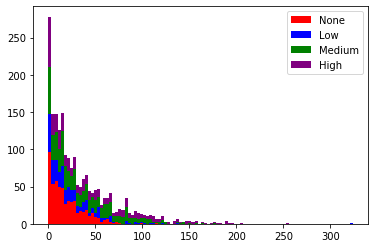

In [41]:
mhnone = full[(full['MentalHealthStatus'] == "None") & (pd.notnull(full['JailstayLength']))]['JailstayLength'].tolist()
mhlow = full[(full['MentalHealthStatus'] == "Low") & (pd.notnull(full['JailstayLength']))]['JailstayLength'].tolist()
mhmed = full[(full['MentalHealthStatus'] == "Medium") & (pd.notnull(full['JailstayLength']))]['JailstayLength'].tolist()
mhhigh = full[(full['MentalHealthStatus'] == "High") & (pd.notnull(full['JailstayLength']))]['JailstayLength'].tolist()

all_mh = [mhnone, mhlow, mhmed, mhhigh]

colors = ['red', 'blue', 'green','purple']
labels = ['None', 'Low', 'Medium','High']

pyplot.hist(all_mh, 100, histtype='bar', stacked=True, color=colors, label = labels)
# pyplot.hist(mhnone, bins, alpha=0.5, label='None')
# pyplot.hist(mhlow, bins, alpha=0.5, label='Low')
# pyplot.hist(mhmed, bins, alpha=0.5, label='Medium')
# pyplot.hist(mhhigh, bins, alpha=0.5, label='High')

pyplot.legend(loc='upper right')
pyplot.show()

`df1.join(df2)` - keeping all rows of df1 and joining to an index in df2